참고) 구글 코랩에서 바른 사용하기 : https://bareun.ai/docs

In [1]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [50]:
# 라이브러리
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import sklearn as sk
import tensorflow as tk
from tensorflow import keras

import warnings

warnings.filterwarnings(action='ignore')
%config InlineBackend.figure_format = 'retina'

In [12]:
# 데이터 불러오기
dataset_path = '/content/drive/MyDrive/value up/dataset/'
data = pd.read_csv(dataset_path + 'BukGu.csv')

data.head()

,content,dept
0,매천동 청구 장미아파트 삼우 그린 입구 불합리 위치 매천동 청구 장미아파트 삼우 그...,도시국 건설과
1,처리 중 언제까지 어린이보호구역 불법주차 불법적 재 신고한 지가 언제인데 아직 처리...,도시국 도시행정과
2,도로 개설 본인은 대구시 북구 태전동 번지 토지 소유자입니다 현재 상기 토지에서 농...,도시국 건설과
3,북구청장 감사실은 뭐 하는 곳입니까 묻습니다 불법에 대한 최고의 북구 전문가 북구청...,감사실
4,대구시장 북구청장 감사실은 뭐 하는 부서입니까 감사실 폐쇄하셔요 미관지구 대구시장 ...,감사실


In [28]:
# X, y 분리
X = data.loc[:, 'content'].values
y = data.loc[:, 'dept'].values

X.shape, y.shape

((6836,), (6836,))

In [29]:
# X_train, X_valid, y_train, y_valid 분리
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((5468,), (1368,), (5468,), (1368,))

In [15]:
# 바른 다운로드 (리눅스 설치본)
!curl -LJks -H "uname:$(uname -a)" https://bareun.ai/api/get -o bareun-linux.deb
!ls

bareun-linux.deb  drive  sample_data


In [16]:
# 바른 설치
!uname -a
!dpkg -i bareun-linux.deb

Linux 9581b33ed35b 5.10.147+ #1 SMP Sat Dec 10 16:00:40 UTC 2022 x86_64 x86_64 x86_64 GNU/Linux
Selecting previously unselected package bareun.
(Reading database ... 122518 files and directories currently installed.)
Preparing to unpack bareun-linux.deb ...
Unpacking bareun (2.0.3) ...
Setting up bareun (2.0.3) ...
System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to connect to bus: Host is down
System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to connect to bus: Host is down
Created symlink /etc/systemd/system/multi-user.target.wants/bareun.service → /etc/systemd/system/bareun.service.


In [17]:
# GPU를 이용하기 위한 tensorflow 설치
!curl -O https://storage.googleapis.com/tensorflow/libtensorflow/libtensorflow-gpu-linux-x86_64-2.9.1.tar.gz
!tar -C /opt/bareun -xzf libtensorflow-gpu-linux-x86_64-2.9.1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  392M  100  392M    0     0   180M      0  0:00:02  0:00:02 --:--:--  180M


In [18]:
# 환경 설정하기
%env BAREUN_ROOT="/opt/bareun"
%env LD_LIBRARY_PATH="/opt/bareun/lib"
!BAREUN_ROOT="/opt/bareun" LD_LIBRARY_PATH="/opt/bareun/lib" nohup /opt/bareun/bin/bareun&

env: BAREUN_ROOT="/opt/bareun"
env: LD_LIBRARY_PATH="/opt/bareun/lib"
nohup: appending output to 'nohup.out'


In [19]:
# 바른 서버가 실행된 정보 표시
!ps -ef | grep bareun

root        2341       1  0 11:03 ?        00:00:00 /opt/bareun/bin/bareun
root        2346     198  0 11:03 ?        00:00:00 /bin/bash -c ps -ef | grep bareun
root        2348    2346  0 11:03 ?        00:00:00 grep bareun


In [20]:
# API키 등록 ('200 OK' 문구 확인)
!BAREUN_ROOT="/opt/bareun" LD_LIBRARY_PATH="/opt/bareun/lib" /opt/bareun/bin/bareun -reg koba-RBKJYUY-YKLU76Q-UXI6RFY-JXP6MRA

Use config file: /opt/bareun/config/bareun.json

------
200 OK
sucessfully registered koba-RBKJYUY-YKLU76Q-UXI6RFY-JXP6MRA


In [21]:
# PIP 패키지 설치
!pip install -U bareunpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
# 바른 Python 라이브러리 사용
import sys
import bareunpy as brn
import google.protobuf.text_format as tf
API_KEY = "koba-RBKJYUY-YKLU76Q-UXI6RFY-JXP6MRA"

# 바른 형태소 분석기 선언
t = brn.Tagger(API_KEY, "localhost", 5656)

In [23]:
# 텍스트 입력 -> 형태소 분석 결과를 리스트로 반환
def bareun_transform(text):
    # 500자 단위로 슬라이싱
    ready_list = []
    while (len(text) > 500):
        temp_str = text[:500]
        last_space = temp_str.rfind(' ') # 앞에서 가장 가까운 공백 ' ' 위치를 찾는다
        temp_str = text[0:last_space]
        ready_list.append(temp_str) # 문자열을 약 500자 단위로 나누어 리스트에 추가한다.

        text = text[last_space:] # 슬라이싱 한 문자는 text에서 제거
    ready_list.append(text) # 500자 이하로 남은 문자열을 마지막에 추가한다.
    
    result_list = []
    for ready in ready_list:
        result = t.tags([ready]).morphs()
        result_list.append(result)

    return sum(result_list, [])

In [31]:
%%time
from sklearn.feature_extraction.text import CountVectorizer

# CountVectorizer로 n-gram 생성
vectorizer = CountVectorizer(min_df=2, tokenizer=bareun_transform, ngram_range=(1, 2)).fit(X_train)

# vectorizer.vocabulary_ 출력
vectorizer.vocabulary_

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CPU times: user 20.7 s, sys: 1.68 s, total: 22.4 s
Wall time: 16min 33s


{'가계': 4973,
 '출입문': 79515,
 '앞': 50830,
 '우천': 59632,
 '시': 45754,
 '물고임': 34542,
 '현상': 84455,
 '해결': 83764,
 '요구': 59034,
 '원인': 60048,
 '인도블록': 68785,
 '침하': 80153,
 '로': 29218,
 '물': 34494,
 '고임': 10635,
 '이': 65972,
 '많': 31582,
 '아': 47868,
 '출입하': 79519,
 '는데': 20329,
 '지장': 76740,
 '으니': 60907,
 '조속히': 73620,
 '조치하': 73782,
 '주': 74309,
 '고': 9029,
 '또': 28156,
 '한': 83183,
 '가지': 5427,
 '도로변': 25779,
 '형': 84762,
 '측구': 79704,
 '에': 53623,
 '도': 24742,
 '있': 69702,
 '조치': 73733,
 '부탁': 38993,
 '드리': 27068,
 'ㅂ니다': 2746,
 '우천 시': 59633,
 '시 물고임': 45861,
 '물고임 현상': 34543,
 '인도블록 침하': 68794,
 '앞 인도블록': 50910,
 '침하 로': 80156,
 '시 물': 45860,
 '물 고임': 34497,
 '고임 현상': 10636,
 '현상 이': 84462,
 '이 많': 66487,
 '많 아': 31599,
 '는데 지장': 20718,
 '지장 이': 76744,
 '많 으니': 31605,
 '으니 조속히': 60970,
 '조속히 조치하': 73626,
 '조치하 아': 73792,
 '아 주': 48608,
 '주 시': 74360,
 '시 고': 45783,
 '고 또': 9409,
 '또 한': 28223,
 '한 가지': 83187,
 '앞 도로변': 50856,
 '측구 에': 79705,
 '에 도': 54027,
 '이 있': 67126,
 '있 으니': 6

In [32]:
len(vectorizer.vocabulary_) # 추출한 단어의 종류는 총 ____개이다.

86221

In [34]:
%%time
x_train = vectorizer.transform(X_train) # 벡터로 변환
x_valid = vectorizer.transform(X_valid)

CPU times: user 25.9 s, sys: 1.93 s, total: 27.8 s
Wall time: 20min 45s


In [ ]:
# ## One-Hot Encoding
# from sklearn.preprocessing import LabelEncoder

# le = LabelEncoder()
# y_train = le.fit_transform(y_train)
# # y_valid = le.transform(y_valid) # 지금은 데이터 수 적게 해서 테스트 하지만 나중에 본 데이터로 작업 시 활용

# print("변경 후 :", y_train) # 변경 후 하나 출력

In [36]:
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((5468, 86221), (1368, 86221), (5468,), (1368,))

In [37]:
# 모델링 시작

In [41]:
result_acc = {}
result_f1 = {}

In [42]:
from sklearn.naive_bayes import MultinomialNB

# MultinomialNB를 사용하여 분류 모델을 학습함
mnb = MultinomialNB()
mnb.fit(x_train, y_train)

MultinomialNB()

y_valid: ['도시국 교통과' '감사실' '감사실' '도시국 건축주택과' '읍/면/동사무소' '도시국 건축주택과' '감사실' '도시국 건설과'
 '도시국 교통과' '도시국 건설과']
y_pred: ['도시국 교통과' '감사실' '감사실' '도시국 건축주택과' '도시국 교통과' '도시국 건축주택과' '감사실' '도시국 교통과'
 '도시국 교통과' '도시국 건설과']
accuracy: 0.6878654970760234
f1 score: 0.48137142725958854


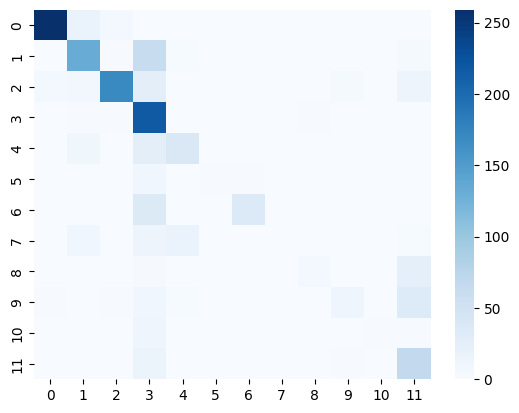

               precision    recall  f1-score   support

          감사실       0.96      0.91      0.94       285
      도시국 건설과       0.71      0.64      0.67       206
    도시국 건축주택과       0.90      0.73      0.81       231
      도시국 교통과       0.50      0.97      0.66       224
    도시국 도시관리과       0.60      0.49      0.54        78
    도시국 도시행정과       0.67      0.11      0.19        18
    도시국 재난안전과       0.92      0.49      0.64        73
  문화녹지국 공원녹지과       0.00      0.00      0.00        45
  복지환경국 자원순환과       0.70      0.19      0.30        37
  복지환경국 환경관리과       0.60      0.18      0.28        65
     읍/면/동사무소       1.00      0.11      0.19        19
주민생활지원국 환경관리과       0.44      0.77      0.56        87

     accuracy                           0.69      1368
    macro avg       0.67      0.47      0.48      1368
 weighted avg       0.72      0.69      0.67      1368



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

y_pred = mnb.predict(x_valid)

print('y_valid:', y_valid[:10])
print('y_pred:', y_pred[:10])


print('accuracy:', accuracy_score(y_valid, y_pred))
print('f1 score:', f1_score(y_valid, y_pred, average='macro'))

sns.heatmap(confusion_matrix(y_valid, y_pred), cmap='Blues')
plt.show()

print(classification_report(y_valid, y_pred))

result_acc['lda'] = accuracy_score(y_valid, y_pred)
result_f1['lda'] = f1_score(y_valid, y_pred, average='macro')

In [48]:
# random forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=400, random_state=1)

rf.fit(x_train, y_train)

RandomForestClassifier(n_estimators=400, random_state=1)

y_valid: ['도시국 교통과' '감사실' '감사실' '도시국 건축주택과' '읍/면/동사무소' '도시국 건축주택과' '감사실' '도시국 건설과'
 '도시국 교통과' '도시국 건설과']
y_pred: ['도시국 교통과' '감사실' '감사실' '도시국 건축주택과' '읍/면/동사무소' '도시국 건축주택과' '감사실' '도시국 건설과'
 '도시국 교통과' '도시국 건설과']
accuracy: 0.7214912280701754
f1 score: 0.5012444555328518


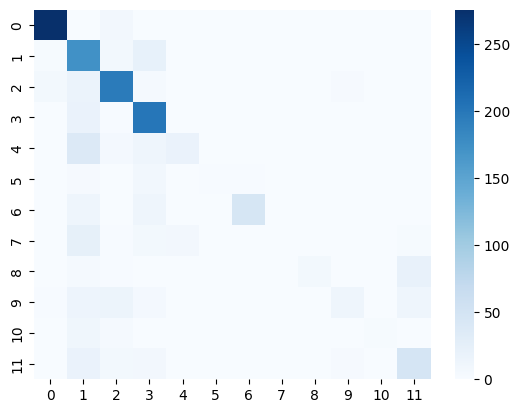

               precision    recall  f1-score   support

          감사실       0.96      0.97      0.96       285
      도시국 건설과       0.51      0.84      0.64       206
    도시국 건축주택과       0.78      0.85      0.81       231
      도시국 교통과       0.70      0.90      0.79       224
    도시국 도시관리과       0.70      0.24      0.36        78
    도시국 도시행정과       1.00      0.11      0.20        18
    도시국 재난안전과       0.96      0.63      0.76        73
  문화녹지국 공원녹지과       0.50      0.02      0.04        45
  복지환경국 자원순환과       0.88      0.19      0.31        37
  복지환경국 환경관리과       0.61      0.22      0.32        65
     읍/면/동사무소       1.00      0.16      0.27        19
주민생활지원국 환경관리과       0.55      0.55      0.55        87

     accuracy                           0.72      1368
    macro avg       0.76      0.47      0.50      1368
 weighted avg       0.74      0.72      0.69      1368



In [49]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

y_pred = rf.predict(x_valid)

print('y_valid:', y_valid[:10])
print('y_pred:', y_pred[:10])

print('accuracy:', accuracy_score(y_valid, y_pred))
print('f1 score:', f1_score(y_valid, y_pred, average='macro'))

sns.heatmap(confusion_matrix(y_valid, y_pred), cmap='Blues')
plt.show()

print(classification_report(y_valid, y_pred))

result_acc['rf'] = accuracy_score(y_valid, y_pred)
result_f1['rf'] = f1_score(y_valid, y_pred, average='macro')

In [51]:
!pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [54]:
x_train_float = x_train.astype(np.float32)  # 데이터를 np.float32 타입으로 변환
x_valid_float = x_valid.astype(np.float32)  # 데이터를 np.float32 타입으로 변환

In [57]:
%%time
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(n_estimators=300, random_state=1)

lgbm.fit(x_train_float, y_train)

CPU times: user 3min 36s, sys: 1.04 s, total: 3min 37s
Wall time: 2min 25s


LGBMClassifier(n_estimators=300, random_state=1)

y_valid: ['도시국 교통과' '감사실' '감사실' '도시국 건축주택과' '읍/면/동사무소' '도시국 건축주택과' '감사실' '도시국 건설과'
 '도시국 교통과' '도시국 건설과']
y_pred: ['도시국 교통과' '감사실' '감사실' '도시국 건축주택과' '읍/면/동사무소' '도시국 건축주택과' '감사실' '도시국 건설과'
 '도시국 교통과' '도시국 건설과']
accuracy: 0.7828947368421053
f1 score: 0.6518406880966333


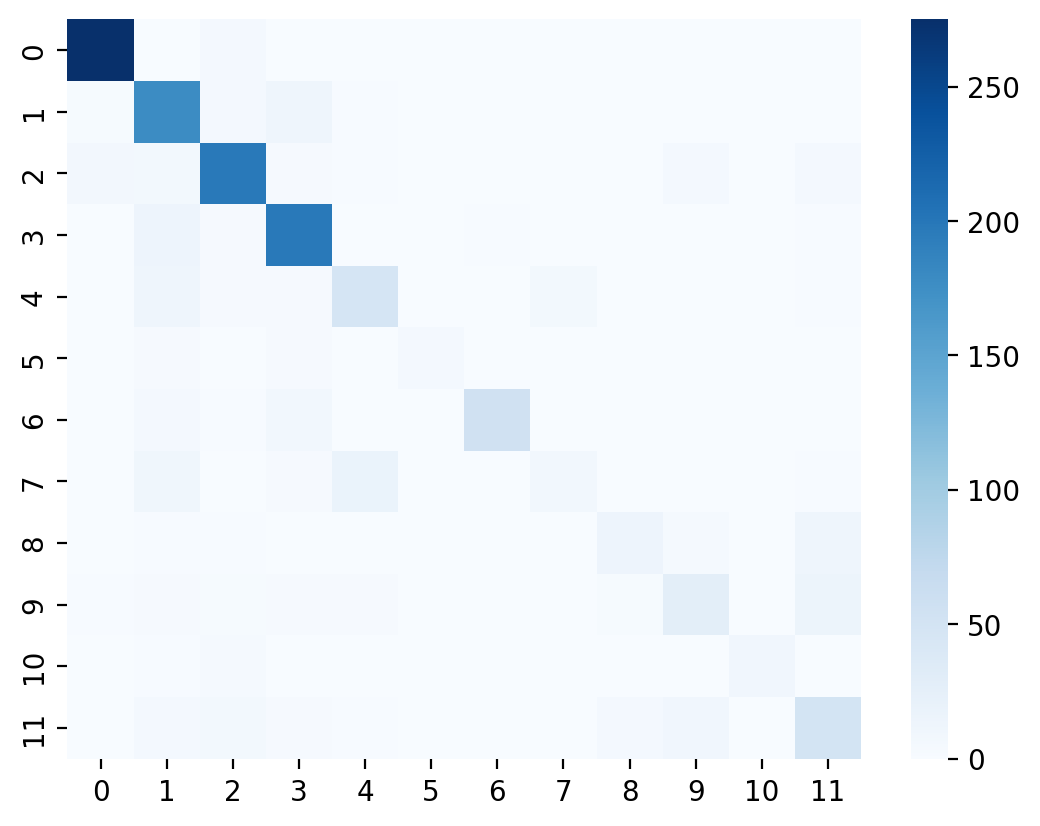

               precision    recall  f1-score   support

          감사실       0.95      0.96      0.96       285
      도시국 건설과       0.71      0.86      0.78       206
    도시국 건축주택과       0.83      0.86      0.84       231
      도시국 교통과       0.81      0.88      0.85       224
    도시국 도시관리과       0.61      0.62      0.61        78
    도시국 도시행정과       0.86      0.33      0.48        18
    도시국 재난안전과       0.90      0.75      0.82        73
  문화녹지국 공원녹지과       0.45      0.20      0.28        45
  복지환경국 자원순환과       0.60      0.41      0.48        37
  복지환경국 환경관리과       0.56      0.45      0.50        65
     읍/면/동사무소       0.91      0.53      0.67        19
주민생활지원국 환경관리과       0.54      0.57      0.56        87

     accuracy                           0.78      1368
    macro avg       0.73      0.62      0.65      1368
 weighted avg       0.78      0.78      0.77      1368



In [58]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

y_pred = lgbm.predict(x_valid_float)

print('y_valid:', y_valid[:10])
print('y_pred:', y_pred[:10])


print('accuracy:', accuracy_score(y_valid, y_pred))
print('f1 score:', f1_score(y_valid, y_pred, average='macro'))

sns.heatmap(confusion_matrix(y_valid, y_pred), cmap='Blues')
plt.show()

print(classification_report(y_valid, y_pred))

result_acc['lgbm'] = accuracy_score(y_valid, y_pred)
result_f1['lgbm'] = f1_score(y_valid, y_pred, average='macro')

In [59]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 13.7 MB/s eta 0:00:00


In [61]:
%%time
from catboost import CatBoostClassifier
cb = CatBoostClassifier(random_state=1, task_type='GPU')

cb.fit(x_train, y_train, verbose=0)

CPU times: user 2min 2s, sys: 44.7 s, total: 2min 46s
Wall time: 2min 35s


y_valid: ['도시국 교통과' '감사실' '감사실' '도시국 건축주택과' '읍/면/동사무소' '도시국 건축주택과' '감사실' '도시국 건설과'
 '도시국 교통과' '도시국 건설과']
y_pred: [['도시국 교통과']
 ['감사실']
 ['감사실']
 ['도시국 건축주택과']
 ['읍/면/동사무소']
 ['도시국 건축주택과']
 ['감사실']
 ['도시국 건설과']
 ['도시국 교통과']
 ['도시국 건설과']]
accuracy: 0.7624269005847953
f1 score: 0.632486300822333


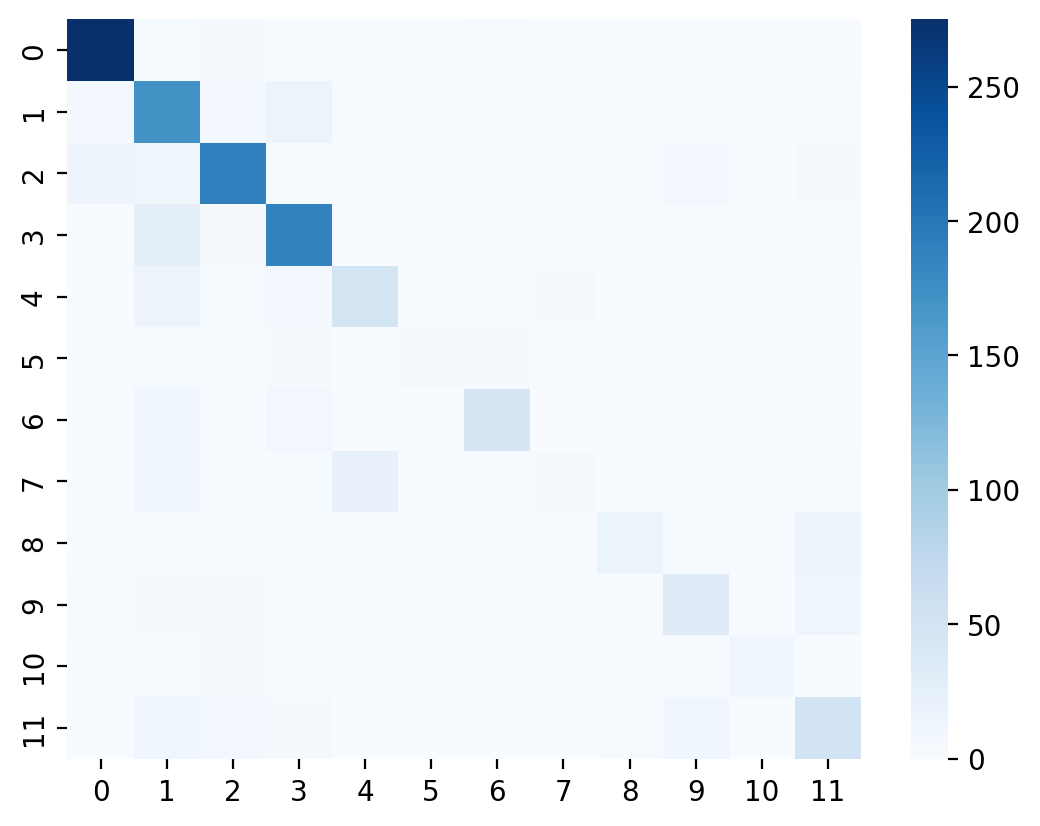

               precision    recall  f1-score   support

          감사실       0.92      0.96      0.94       285
      도시국 건설과       0.63      0.83      0.71       206
    도시국 건축주택과       0.83      0.83      0.83       231
      도시국 교통과       0.80      0.83      0.81       224
    도시국 도시관리과       0.65      0.64      0.65        78
    도시국 도시행정과       1.00      0.22      0.36        18
    도시국 재난안전과       0.82      0.64      0.72        73
  문화녹지국 공원녹지과       0.40      0.09      0.15        45
  복지환경국 자원순환과       0.81      0.46      0.59        37
  복지환경국 환경관리과       0.61      0.52      0.56        65
     읍/면/동사무소       0.85      0.58      0.69        19
주민생활지원국 환경관리과       0.56      0.60      0.58        87

     accuracy                           0.76      1368
    macro avg       0.74      0.60      0.63      1368
 weighted avg       0.76      0.76      0.75      1368



In [62]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

y_pred = cb.predict(x_valid)

print('y_valid:', y_valid[:10])
print('y_pred:', y_pred[:10])


print('accuracy:', accuracy_score(y_valid, y_pred))
print('f1 score:', f1_score(y_valid, y_pred, average='macro'))

sns.heatmap(confusion_matrix(y_valid, y_pred), cmap='Blues')
plt.show()

print(classification_report(y_valid, y_pred))

result_acc['cb'] = accuracy_score(y_valid, y_pred)
result_f1['cb'] = f1_score(y_valid, y_pred, average='macro')

In [64]:
x_train_arr = x_train.toarray()
x_valid_arr = x_valid.toarray()

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()

lda.fit(x_train_arr, y_train)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

y_pred = lda.predict(x_valid_arr)

print('y_valid:', y_valid[:10])
print('y_pred:', y_pred[:10])


print('accuracy:', accuracy_score(y_valid, y_pred))
print('f1 score:', f1_score(y_valid, y_pred, average='macro'))

sns.heatmap(confusion_matrix(y_valid, y_pred), cmap='Blues')
plt.show()

print(classification_report(y_valid, y_pred))

result_acc['lda'] = accuracy_score(y_valid, y_pred)
result_f1['lda'] = f1_score(y_valid, y_pred, average='macro')

In [ ]:
### acc 비교
# 데이터프레임 만들기
df = pd.DataFrame.from_dict(result_acc, orient='index', columns=['score'])
df.sort_values(by='score', ascending=True, inplace=True)

# 성능 비교
plt.figure(figsize=(8, 5))
plt.barh(y=df.index, width=df['score'])
plt.xlabel('Score')
plt.ylabel('Model')
plt.xlim(0,1)
plt.grid()
plt.show()

In [ ]:
### f1 비교
# 데이터프레임 만들기
df = pd.DataFrame.from_dict(result_f1, orient='index', columns=['score'])
df.sort_values(by='score', ascending=True, inplace=True)

# 성능 비교
plt.figure(figsize=(8, 5))
plt.barh(y=df.index, width=df['score'])
plt.xlabel('Score')
plt.ylabel('Model')
plt.xlim(0,1)
plt.grid()
plt.show()